In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
## Complete Latent Factor Model
train = pd.read_csv('dataset/interactions_train.csv')
dataset=train
len(train)


dataset.columns
full=pd.read_csv('dataset/RAW_interactions.csv')
full.columns
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
#print(len(dataset))
for index,d in full.iterrows():
    user,item = full['user_id'][index], full['recipe_id'][index]
    #print(user,item)
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

ratingMean = sum([dataset['rating'][index] for index,d in dataset.iterrows()]) / len(dataset)
alpha = ratingMean

N = len(dataset)
nUsers = len(reviewsPerUser)
nItems = len(reviewsPerItem)
users = list(reviewsPerUser.keys())
items = list(reviewsPerItem.keys())

userBiases = defaultdict(float)
itemBiases = defaultdict(float)
userGamma = {}
itemGamma = {}
import random


def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(dataset['user_id'][index], dataset['recipe_id'][index]) for index,d in dataset.iterrows()]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in reviewsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in reviewsPerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for index,d in dataset.iterrows():
        u,i = dataset['user_id'][index], dataset['recipe_id'][index]
        pred = prediction(u, i)
        diff = pred - dataset['rating'][index]
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return np.array(dtheta)
alwaysPredictMean = [ratingMean for index,d in dataset.iterrows()]
labels_train = [dataset['rating'][index] for index,d in dataset.iterrows()]

MSE(alwaysPredictMean, labels_train)




0.9197221984648947

In [2]:
K = 2
for u in reviewsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in reviewsPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [3]:
import scipy
import scipy.optimize
test = pd.read_csv('dataset/interactions_test.csv')
MSES_lrs_test=[]
MSES_Ks_test=[]
def train_predict(lr,K):
    print(lr,K)
    scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                    [0.0]*(nUsers+nItems) + # Initialize beta
                                    [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                                derivative, args = (labels_train, lr))


    
    
    labels = [dataset['rating'][index] for index,d in test.iterrows()]
    y_pred=[]
    for i, d in test.iterrows():
        if(user not in userBiases or item not in itemBiases):
            y_pred.append(ratingMean)
            continue
        y_pred.append(prediction(test['user_id'][i],test['recipe_id'][i]))
    MSE_val=MSE(y_pred,labels)
    print("total_MSE= ",MSE_val)
    return MSE_val


## lrs plot

In [4]:
lr=0.001
K=2
MSES_lrs_test.append(train_predict(lr,K))
MSES_lrs_test

0.001 2
MSE = 0.9197197459483603
MSE = 0.9155331456893117
MSE = 0.9041221354911783
MSE = 34.411261969571264
MSE = 0.9222340443181656
MSE = 0.9469055509843352
MSE = 0.9256319554653247
MSE = 0.8744938621042585
MSE = 0.8745805981437731
MSE = 0.877822218637879
MSE = 0.8788094809077236
MSE = 0.8788425667418226
MSE = 0.8789700589747245
MSE = 0.8791022927143849
MSE = 0.8791798034512613
MSE = 0.8791922341751299
MSE = 0.8791933695119344
MSE = 0.8791926654609814
MSE = 0.8791905151158239
total_MSE=  1.1564688760711084


[1.1564688760711084]

In [5]:
lr=0.0005
K=2
MSES_lrs_test.append(train_predict(lr,K))
MSES_lrs_test

0.0005 2
MSE = 0.9209978765958075
MSE = 1.6870902961507899
MSE = 0.9196155237496403
MSE = 0.9194635393083213
MSE = 0.9188614542692989
MSE = 0.9165467577268045
MSE = 0.9087862688555112
MSE = 0.888445536988704
MSE = 0.9791253260214697
MSE = 0.8700743111483046
MSE = 0.8587013727084758
MSE = 0.8585882852992046
MSE = 0.8601078382962419
MSE = 0.8624349586152941
MSE = 0.8630366118358774
MSE = 0.8627032358831555
MSE = 0.8627844362539234
MSE = 0.8631047255175766
MSE = 0.8632582016060193
MSE = 0.8634374015283042
MSE = 0.8632708586880606
MSE = 0.8632729655845114
MSE = 0.8632834049186126
total_MSE=  1.1559832455720653


[1.1564688760711084, 1.1559832455720653]

In [6]:
lr=0.0001
K=2
MSES_lrs_test.append(train_predict(lr,K))
MSES_lrs_test

0.0001 2
MSE = 0.9220417899828514
MSE = 1.7954948390198082
MSE = 0.919587857634295
MSE = 0.9194571928050257
MSE = 0.9189388593939902
MSE = 0.916934740249072
MSE = 0.9100256956290983
MSE = 0.8842329756179638
MSE = 0.8691862757447726
MSE = 0.8598131853629457
MSE = 0.8404244742122685
MSE = 0.834252734359624
MSE = 0.8237809967236418
MSE = 0.8196364425170369
MSE = 0.8107797419626678
MSE = 0.8097134835727603
MSE = 0.8090191095666245
MSE = 0.8094105765109433
MSE = 0.8104474989974829
MSE = 0.8092893230416691
MSE = 0.8092514684341465
MSE = 0.8095242725712055
MSE = 0.8097575676180198
MSE = 0.8106058873145997
MSE = 0.8105022771872018
MSE = 0.8104448223658458
MSE = 0.810583080752428
MSE = 0.8108052511936265
MSE = 0.8112084611741159
MSE = 0.8113864366760857
MSE = 0.8112498229336279
MSE = 0.8112176187186249
MSE = 0.8112305303479077
MSE = 0.8111920409960512


KeyboardInterrupt: 

In [7]:
labels = [dataset['rating'][index] for index,d in test.iterrows()]
y_pred=[]
for i, d in test.iterrows():
    if(user not in userBiases or item not in itemBiases):
        y_pred.append(ratingMean)
        continue
    y_pred.append(prediction(test['user_id'][i],test['recipe_id'][i]))
MSE_val=MSE(y_pred,labels)
print("total_MSE= ",MSE_val)

total_MSE=  1.1621894063159954


In [8]:
MSES_lrs_test.append(1.1621894063159954)
lrs=[0.001,0.0005,0.0001]

In [13]:
lrs=[0.001,0.0005,0.0001]
MSES_lrs_test

[1.1564688760711084, 1.1559832455720653, 1.1621894063159954]

Text(0, 0.5, 'Mean squared error')

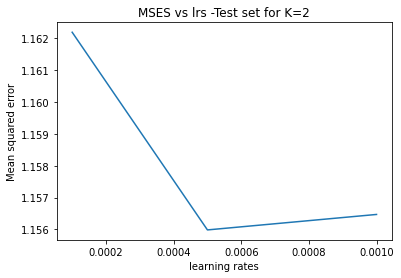

In [17]:
import matplotlib.pyplot as plt
plt.plot(lrs,MSES_lrs_test)
plt.title("MSES vs lrs -Test set for K=2")
plt.xlabel("learning rates")
plt.ylabel("Mean squared error")


Text(0, 0.5, 'Mean squared error')

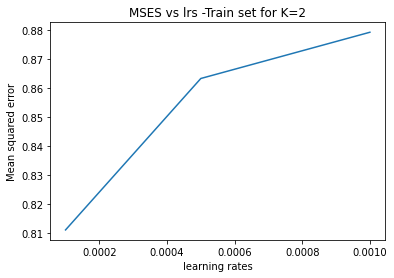

In [18]:
MSES_lrs_train=[0.8791905151158239,0.8632834049186126,0.8111920409960512]
plt.plot(lrs,MSES_lrs_train)
plt.title("MSES vs lrs -Train set for K=2")
plt.xlabel("learning rates")
plt.ylabel("Mean squared error")

## KS


In [9]:
lr=0.001
K=3
MSES_Ks_test.append(train_predict(lr,K))
MSES_Ks_test

0.001 3
MSE = 0.9269594776015013
MSE = 1.6258449001093056
MSE = 0.919749263046449
MSE = 0.9196012331066785
MSE = 0.9190146395289586
MSE = 0.916756684037286
MSE = 0.9091395579462094
MSE = 1.4764208255245665
MSE = 0.9437236800860124
MSE = 0.8791755867202871
MSE = 0.8780212320691136
MSE = 0.878117971300233
MSE = 0.8785286943060684
MSE = 0.8791582219663377
MSE = 0.8791867956137979
MSE = 0.8791702273208531
MSE = 0.8791776705830772
total_MSE=  1.1564686208293464


[1.1564686208293464]

In [10]:
lr=0.001
K=6
MSES_Ks_test.append(train_predict(lr,K))
MSES_Ks_test

0.001 6
MSE = 0.9210014953578174
MSE = 1.2290031334514997
MSE = 0.9236626560320034
MSE = 0.9232802447519272
MSE = 0.9217840685179892
MSE = 0.9163348626106562
MSE = 0.9031058313796867
MSE = 1.0876611722965945
MSE = 1.0199243183433226
MSE = 0.8761080228638937
MSE = 0.8763513655300197
MSE = 0.8779862260990471
MSE = 0.8789178969036101
MSE = 0.8792151234805938
MSE = 0.8791218462254424


KeyboardInterrupt: 

In [20]:
KS_test=[0.8791905151158239,0.8791776705830772,0.8791708476995351]
KS=[2,3,5]
KS_train=[1.1564688760711084,1.1564686208293464,1.1564680279791055]


Text(0, 0.5, 'Mean squared error')

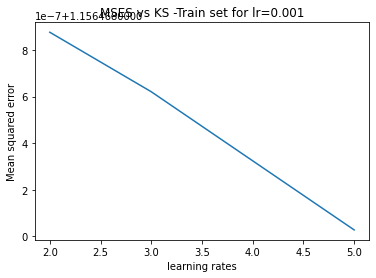

In [21]:

plt.plot(KS,KS_train)
plt.title("MSES vs KS -Train set for lr=0.001")
plt.xlabel("learning rates")
plt.ylabel("Mean squared error")

Text(0, 0.5, 'Mean squared error')

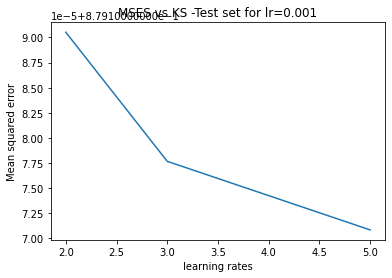

In [22]:
import matplotlib.pyplot as plt
plt.plot(KS,KS_test)
plt.title("MSES vs KS -Test set for lr=0.001")
plt.xlabel("learning rates")
plt.ylabel("Mean squared error")